In [1]:
#Imports
import os
import copy
import sys
import csv
from sigfig import round
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import netCDF4
from shapely.geometry import Point, LineString, MultiPoint
from scipy.interpolate import griddata
import scipy.interpolate
import scipy
import cmocean
from sklearn import datasets, preprocessing
from eofs.standard import Eof                              #EOFs!!
from scipy import stats
import gsw

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/')
#Import custom functions
from read_CTD import read_CTD    #To read CTD files
from out_outliers import out_outliers     #To replace outliers
import plotting_functions as plot   #To plot vertical profiles, T-S and vertical sections
from maps import mapa, map_layers    #To plot maps
from stations import stations
from transsects import select_transsects
from distance import distances
from dict_units import dict_units

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/distance')
from distances import *

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/transsects_functions/')
from bathymetry_transsects import bathymetry_transsects
from transsect_distances import transsect_distances
from transsects_dataconc import transsects_dataconc

from matplotlib.colors import Normalize
class PiecewiseNorm(Normalize):
    def __init__(self, levels, clip=False):
        # the input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))

In [2]:
#Data reading and outlier replacement
data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_proc_files_1mbin/']
data=read_CTD(data_dirs)

for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)
    data[ncast]['pressure'] = data[ncast].index
    data[ncast].index = np.arange(0, len(data[ncast].index))

#Dict with all transsects
all_transsects = {'transsect_0':['15','12','13','14'],
                  'transsect_1':['19','18','17','16'],
                  'transsect_2':['24','23','22','21'],
                  'transsect_3':['26','27','28','29'],
                  'transsect_4':['31','32','33','34'],
                  'transsect_5':['38','37','36','35'],
                  'transsect_6':['43','44','45','46']}

#Dict with the stations grouped according to its position
all_stations_grouped = {}
for i in range(len(list(all_transsects.values())[0])):
    key = 'stations_'+str(i+1)
    all_stations_grouped[key]=[]
    for transsect in all_transsects.values():
        all_stations_grouped[key].append(transsect[i])

all_transsects['transsect_0_v2'] = ['11','12','13','14']
all_transsects['transsect_0_v3'] = ['15','11','12','13','14']
all_transsects['transsect_lat'] = ['09', '10', '15', '19', '24', '26', '31', '38', '43', '47']
all_transsects['transsect_port'] = ['15', '19', '24', '26', '31', '38', '43']
all_transsects['transsect_port_v2'] = ['24', '26', '31']
all_transsects['all_stations'] = list(data.keys())

C:\Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions\read_CTD.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[i].rename(columns=name_columns, inplace=True)


In [3]:
#Import a dictionary with the units of the variables
variables = list(data['09'].keys())
units = dict_units(variables)

# Computing AOU (Apparent Oxygen Utilization)

In [4]:
for ncast in data.keys():
    SA = data[ncast]['salinity'].values
    p = data[ncast]['pressure'].values
    t = data[ncast]['temperature'].values
    CT = gsw.CT_from_t(SA, t, p)
    pt = gsw.pt0_from_t(SA, t, p)
    lon = data[ncast]['longitude'].iloc[0]
    lat = data[ncast]['latitude'].iloc[0]

    O2_sol = gsw.O2sol(SA, CT, p, lon, lat)
        
    O2 = data[ncast]['oxygen']
    
    #AOU is the O2 at saturation minus the measured O2
    AOU = O2_sol -O2
    
    data[ncast]['O2_sol'] = O2_sol
    data[ncast]['AOU'] = AOU

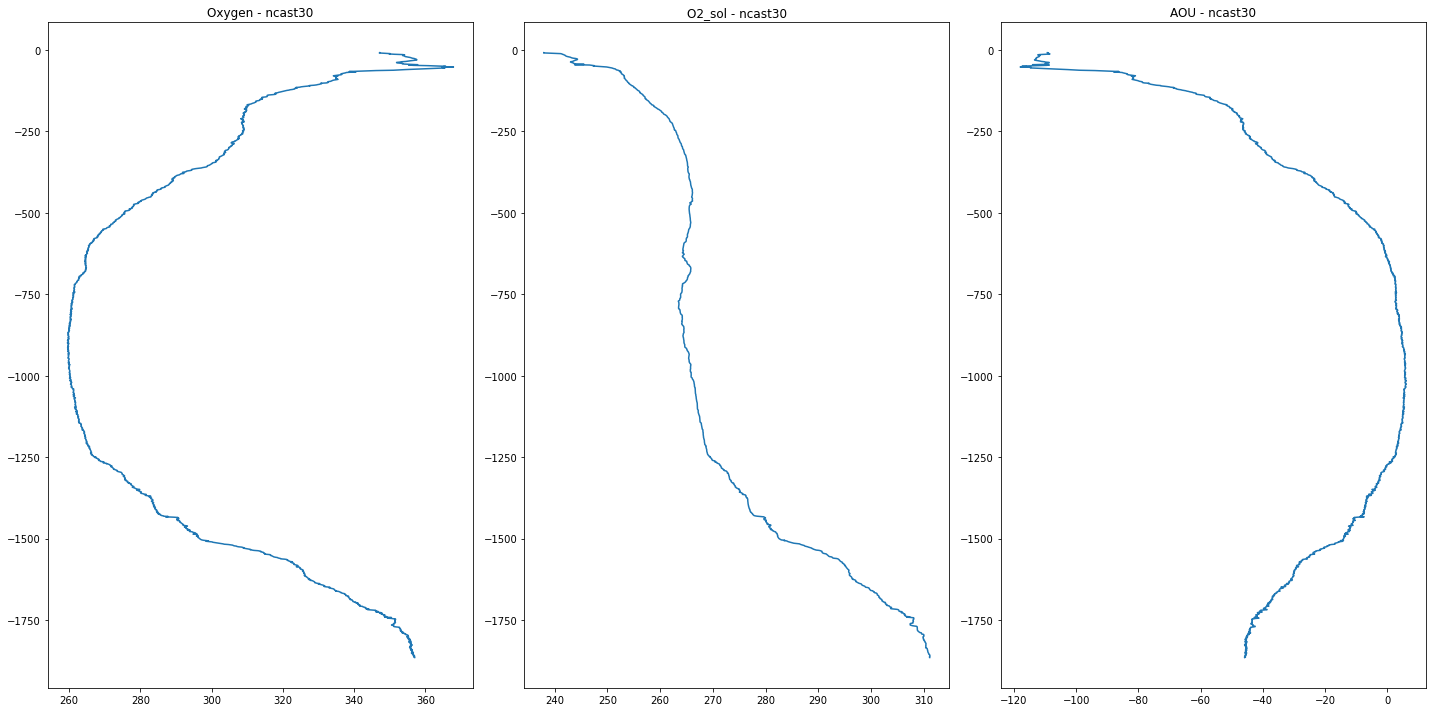

In [5]:
ncast = '30'

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20,10))
ax0.plot(data[ncast]['oxygen'], data[ncast]['depth']*-1)
ax0.set_title('Oxygen - ncast'+ncast)
ax1.plot(data[ncast]['O2_sol'], data[ncast]['depth']*-1)
ax1.set_title('O2_sol - ncast'+ncast)
ax2.plot(data[ncast]['AOU'], data[ncast]['depth']*-1)
ax2.set_title('AOU - ncast'+ncast)

plt.tight_layout()

plt.show()

In [8]:
gsw.O2sol_SP_pt?

Signature: gsw.O2sol_SP_pt(SP, pt)
Docstring:
Calculates the oxygen concentration expected at equilibrium with air at
an Absolute Pressure of 101325 Pa (sea pressure of 0 dbar) including
saturated water vapor.  This function uses the solubility coefficients
derived from the data of Benson and Krause (1984), as fitted by Garcia
and Gordon (1992, 1993).

Parameters
----------
SP : array-like
    Practical Salinity (PSS-78), unitless
pt : array-like
    Potential temperature referenced to a sea pressure, degrees C

Returns
-------
O2sol : array-like, umol/kg
    solubility of oxygen in micro-moles per kg
File:      c:\programdata\miniconda3\lib\site-packages\gsw\_wrapped_ufuncs.py
Type:      function


In [7]:
gsw.O2sol?

Signature: gsw.O2sol(SA, CT, p, lon, lat)
Docstring:
Calculates the oxygen concentration expected at equilibrium with air at
an Absolute Pressure of 101325 Pa (sea pressure of 0 dbar) including
saturated water vapor.  This function uses the solubility coefficients
derived from the data of Benson and Krause (1984), as fitted by Garcia
and Gordon (1992, 1993).

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
CT : array-like
    Conservative Temperature (ITS-90), degrees C
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar
lon : array-like
    Longitude, -360 to 360 degrees
lat : array-like
    Latitude, -90 to 90 degrees

Returns
-------
O2sol : array-like, umol/kg
    solubility of oxygen in micro-moles per kg
File:      c:\programdata\miniconda3\lib\site-packages\gsw\_wrapped_ufuncs.py
Type:      function


In [384]:
#for ncast in data.keys():
#    SA = data[ncast]['salinity'].values
#    p = data[ncast]['pressure'].values
#    t = data[ncast]['temperature'].values
#    CT = gsw.CT_from_t(SA, t, p)
#    pt = gsw.pt0_from_t(SA, t, p)
#    lon = data[ncast]['longitude'].iloc[0]
#    lat = data[ncast]['latitude'].iloc[0]
#
#    #O2_sol = gsw.O2sol_SP_pt(SA, pt)
#    O2_sol = gsw.O2sol(SA, CT, p, lon, lat)
#    
#    #O2_sat = o2sat(s=SA, pt=pt)
#    
#    o2 = data[ncast][]
#    AOU = 
#    
#    data[ncast]['O2_sol'] = O2_sol
#    data[ncast]['O2_sol_v2'] = O2_sol_v2
#    data[ncast]['O2_sat'] = O2_sat

In [9]:
def o2sat(s, pt):
    """
    Calculate oxygen concentration at saturation.  Molar volume of oxygen
    at STP obtained from NIST website on the thermophysical properties of fluid
    systems (http://webbook.nist.gov/chemistry/fluid/).

    Parameters
    ----------
    s : array_like
        Salinity [pss-78]
    pt : array_like
         Potential Temperature [degC ITS-90]

    Returns
    -------
    osat : array_like
          Oxygen concentration at saturation [umol/kg]

    Examples
    --------
    >>> import os
    >>> from pandas import read_csv
    >>> import oceans.seawater.sw_extras as swe
    >>> path = os.path.split(os.path.realpath(swe.__file__))[0]
    # Table 9 pg. 732. Values in ml / kg
    >>> pt = np.array([-1, 0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22,
    ...                24, 26, 28, 30, 32, 34, 36, 38, 40]) / 1.00024
    >>> s = np.array([0, 10, 20, 30, 34, 35, 36, 38, 40])
    >>> s, pt = np.meshgrid(s, pt)
    >>> osat = swe.o2sat(s, pt) * 22.392 / 1000  # um/kg to ml/kg.
    >>> weiss_1979 = read_csv('%s/test/o2.csv' % path, index_col=0).values
    >>> np.testing.assert_almost_equal(osat.ravel()[2:],
    ...                                weiss_1979.ravel()[2:], decimal=3)


    References
    -----
    .. [1] The solubility of nitrogen, oxygen and argon in water and seawater -
    Weiss (1970) Deep Sea Research V17(4): 721-735.
    """

    t = seawater.library.T68conv(pt) + seawater.constants.Kelvin
    # Eqn (4) of Weiss 1970 (the constants are used for units of ml O2/kg).
    a = (-177.7888, 255.5907, 146.4813, -22.2040)
    b = (-0.037362, 0.016504, -0.0020564)
    lnC = (a[0] + a[1] * (100. / t) + a[2] * np.log(t / 100.) + a[3] *
           (t / 100.) +
           s * (b[0] + b[1] * (t / 100.) + b[2] * (t / 100.) ** 2))
    osat = np.exp(lnC) * 1000. / 22.392  # Convert from ml/kg to um/kg.

    # The Apparent Oxygen Utilization (AOU) value was obtained by subtracting
    # the measured value from the saturation value computed at the potential
    # temperature of water and 1 atm total pressure using the following
    # expression based on the data of Murray and Riley (1969):

    # ln(O2 in µmol/kg) = - 173.9894 + 255.5907(100/TK) + 146.4813 ln(TK/100) -
    # 22.2040(TK/100) + Sal [-0.037362 + 0.016504(TK/100) - 0.0020564(TK/100)2],
    # where TK is temperature in °K and Sal in the Practical Salinity (SP) scale.

    return osat